In [1]:
# thompson.py

from scipy.stats import beta
import numpy as np
from scipy.stats import bernoulli
from scipy.stats import norm, randint
import timeit
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:



# Read the dataset into numpy arrray form
#with open("") as infile:
    

################################## Initiate Parameters for the scripts ##################################
# initialize distributions
prob_model = 0 # 0 for bernoulli, 1 for gaussian
#global prior_distribution, rewards_distribution, true_prob

## number of arms

true_prob = np.array([0.2, 0.6, 0.5]) # This represents the click rate for each article
size = len(true_prob)

# bernoulli case for two arms
arms = [bernoulli(true_prob[0]), bernoulli(true_prob[1]), bernoulli(true_prob[2])] 


################################################################################
# Active Arms = active articles ID
active_arms = [i for i in range(size)] # origionally two arms are actives
############################################################
#Time Stamps
time_stamps_1 =[[],[]]
# time_stamps_1 = numpy.zeros(shape=[10, 80000])
# timestamp1_counter = 0
time_stamps_2 = [[],[]]


###########################################################
rounds = 100000 # get the maximum timestamp
phases = int(rounds/10)

n_m = np.zeros(phases)
############################################################
#tolerances
tolerances = np.zeros(phases)
tolerances[0] = 0.5

phase_index = 0
round_index = 0
###########################################################
## Initiate regrets
regret_per_round = np.zeros(rounds) 
cumulated_regrets = np.zeros(rounds)
rewards_per_round = np.zeros((size,rounds), dtype=float)
rewards = np.zeros(rounds, dtype=float)
delays_per_round = np.zeros((size, rounds), dtype=float)
action_per_round = np.ones(rounds, dtype=int) * 10
observations = np.zeros(rounds)
average_observations = np.zeros((size, 200), dtype=float)

#######################################Function Space ###################################

### Delay
delay_distribution = randint(1,100)


### Rewards
def get_expected_reward(chosen, t): 
    # this obtains the empirical expected rewards
    # sum the rewards up to round t-1, including round 0. t represents the current round
    if t:
        return np.sum(rewards_per_round[chosen][:t])/t
    return 0
    
### def regreat
# Register the regret
def register_regret(chosen,t):
    # Calculate regrets
    # best performing articles click rate – the selected articles click rate 
    regret = max(true_prob) -get_expected_reward(chosen,t) # best click rate - the selected click rate
    regret_per_round[t] = regret
    if t > 0:
        cumulated_regrets[t] = regret + cumulated_regrets[t-1] 
    else:
        cumulated_regrets[t] = regret
        
# Calculate_X(T)
def calculate_X(T):
    s = 0
    for arm in active_arms:
        for t in range(T+1):
            if (action_per_round[t] == arm and (t + delays_per_round[arm][t]) == T): 
                s += rewards_per_round[arm][t]
    return s

def apply_action(arm_index,t ):
    
    action_per_round[t] = arm_index
    
    reward = arms[arm_index].rvs()
    
    rewards_per_round[arm_index][t] = reward
    
    rewards[t] = reward
    
    regret_per_round[t] = max(true_prob) - reward
    
    delay = delay_distribution.rvs()
    
    delays_per_round[arm_index][t] = delay
    
    # Receive observations
    observations[t] = calculate_X(t)

    
            



################################################# scripts started ######################################



#best_arm = np.zeros(rounds,dtype = int) * 10

##################################### Complementary Functions ########################################

## Thompson sampling     
#def sampling(size, t):
#    global thetas   
#    thetas = prior_distribution.rvs(hyperparameters[:,0], hyperparameters[:,1])
#
#            
#def stats():
#    # return the mean and the variance of regrets per realization
#    return (regret_per_round.mean(), regret_per_round.var())

def size_of_timestamps(time_stamps):
    i,j = 0, len(time_stamps)-1
    mid = (i + j) / 2
    while not (time_stamps[mid] == 0 and time_stamps[mid-1] > 0):
        if (time_stamps[mid] == 0 and time_stamps[mid-1] == 0):
            j = mid
            mid = (i + j) / 2
        elif (time_stamps[mid] > 0 and time_stamps[mid+1] > 0):
            i = mid
            mid = (i + j) /2
        elif (time_stamps[mid] > 0 and time_stamps[mid+1]  0):
            return mid+1
        
    return mid
            
        
        
    
def start():
    
    t = 0
    phase_index = 0

    C_1 = 10
    C_2 = 10
    
    while t < rounds:
        n_m[phase_index] = C_1 * np.log(rounds*(tolerances[phase_index])**2) / (tolerances[phase_index])**2 + C_2 * (phase_index+1) * delay_distribution.expect() / tolerances[phase_index]
        
        print("n_m is", n_m[phase_index])
        for arm_index in active_arms: # active arms
            # Step 1
            if arm_index == 0:
                # time_stamps_1[1] is T_j(m)
                time_stamps_1[phase_index] += time_stamps_1[phase_index-1]
                while (len(time_stamps_1[1]) < n_m[phase_index] and t < rounds):
                    
                    apply_action(arm_index, t)
                    register_regret(arm_index, t)
                    time_stamps_1[1].append(t)
                    t+=1
                    time_stamps_1[0] = time_stamps_1[1]
                
                    

            elif arm_index == 1:
                time_stamps_2[1] = time_stamps_2[0]
                while (len(time_stamps_2[1]) < n_m[phase_index] and t < rounds):
                    
                    apply_action(arm_index, t)
                    register_regret(arm_index, t)
                    time_stamps_2[1].append(t)
                    t+=1
                    time_stamps_2[0] = time_stamps_2[1]

                    

        # Get average observations and Eliminate suboptimal ars
        for i in active_arms:
            if i == 0:
                s = 0
                for time_stamp in time_stamps_1[0]:
                    s += observations[time_stamp]
                
                average_observations[i][phase_index] = s * 1.0 / len(time_stamps_1[1]) 
                print("average observation for arm 1 is {}".format(average_observations[i][phase_index]))
            elif i == 1:
                s = 0
                for time_stamp in time_stamps_2[0]:
                    s += observations[time_stamp]
                average_observations[i][phase_index] = s * 1.0 / len(time_stamps_2[1]) 
                print("average observation for arm 2 is {}".format(average_observations[i][phase_index]))
        
        #new_active_arms = []
        max_average_observation = max(average_observations[:, phase_index])
        print("max observation is "+ str(max_average_observation))
        print("phase index is "+ str(phase_index))
        print("tolerance is "+str(tolerances[phase_index]))
        
        temp_active_arms = active_arms.copy()
        for arm in temp_active_arms:
            if (average_observations[arm][phase_index]+tolerances[phase_index]) < max_average_observation:
                #print("True")
                #print(active_arm)
                active_arms.remove(arm)
             
        #active_arms = new_active_arms
        #active_arms = new_active_arms
        
        # Decrease Tolerance
        tolerances[phase_index+1] = tolerances[phase_index]/2.0

#         # Bridge period
#         if phase_index >= 1:
#             for t in range(int(n_m[phase_index] - n_m[phase_index-1])):
#                 arm = randint(0,2).rvs()
#                 register_regret(arm_index, t)


                    
        phase_index += 1
        

start()

# def start1():
    
#     t = 0
#     phase_index = 0

#     C_1 = 10
#     C_2 = 10
    
#     while t < rounds:
#         n_m[phase_index] = C_1 * np.log(rounds*(tolerances[phase_index])**2) / (tolerances[phase_index])**2 + C_2 * (phase_index+1) * delay_distribution.expect() / tolerances[phase_index]
    
#     for i in range(rounds):
#         # Delayed Rewards
#         if (i % 10 == 0):
#             # call function by its use
#             sampling(size, i)

#             chosen_arm = thetas.argmax()
#             best_arm[i] = chosen_arm
#             # by choosing the best theta, determine the best arm
#         else:
#             chosen_arm = best_arm[i-1]
#             best_arm[i] = chosen_arm
            
#         # Immediate Rewards:
#         #sampling(size, i)

#         #record_thetas(lines, thetas, size, i)
#         chosen_arm = thetas.argmax()
#         best_arm[i] = chosen_arm
        
#         # apply this arm and observe the rewards. # question: do we use the calculauted result from above 
#         #or need to apply the arm again
#         if rewards_distribution == bernoulli:
#             r = rewards_distribution.rvs(p = true_prob[best_arm[i]])
            
#         else:
#             params = true_prob[chosen_arm]
#             r = rewards_distribution.rvs(params[0], params[1])

#         record_rewards(i, chosen_arm, r)

#         register_regret(chosen_arm, i)

#         update_posteriors(i, r,chosen_arm)

#         record_posteriors(i, hyperparameters)
    

SyntaxError: invalid syntax (<ipython-input-17-03880fe406cd>, line 144)

In [ ]:
# thompson.py

from scipy.stats import beta
import numpy as np
from scipy.stats import bernoulli
from scipy.stats import norm, randint
import timeit
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline


# Read the dataset into numpy arrray form
#with open("") as infile:
    

################################## Initiate Parameters for the scripts ##################################
# initialize distributions
prob_model = 0 # 0 for bernoulli, 1 for gaussian
#global prior_distribution, rewards_distribution, true_prob

## number of arms

true_prob = np.array([0.2, 0.6]) # This represents the click rate for each article
size = len(true_prob)

# bernoulli case for two arms
arms = [bernoulli(true_prob[0]), bernoulli(true_prob[1])] 


################################################################################
# Active Arms = active articles ID
active_arms = [i for i in range(size)] # origionally two arms are actives
############################################################


###########################################################
rounds = 50000 # get the maximum timestamp
phases = int(rounds/10)
time_stamps = np.zeros(shape=[3, 10, 50000])
time_stamps_1 = np.zeros(shape=[10, 50000])
time_stamps_2 = np.zeros(shape=[10, 50000])
time_stamps_3 = np.zeros(shape=[10, 50000])

n_m = np.zeros(phases)

############################################################
#tolerances
tolerances = np.zeros(phases)
tolerances[0] = 0.5

phase_index = 0
round_index = 0
###########################################################
## Initiate regrets
regret_per_round = np.zeros(rounds) 
cumulated_regrets = np.zeros(rounds)
rewards_per_round = np.zeros((size,rounds), dtype=float)
rewards = np.zeros(rounds, dtype=float)
delays_per_round = np.zeros((size, rounds), dtype=float)
action_per_round = np.ones(rounds, dtype=int) * 10
observations = np.zeros(rounds)
average_observations = np.zeros((size, 200), dtype=float)
# cumulative rewards
cumulative_rewards = np.zeros(rounds)

#######################################Function Space ###################################

### Delay
delay_distribution = randint(1,10)


### Rewards
def get_expected_reward(chosen, t): 
    # this obtains the empirical expected rewards
    # sum the rewards up to round t-1, including round 0. t represents the current round
    if t:
        return np.sum(rewards_per_round[chosen][:t])/t
    return 0
    
### def regreat
# Register the regret
def register_regret(chosen,t):
    # Calculate regrets
    # best performing articles click rate – the selected articles click rate 
    regret = max(true_prob) -get_expected_reward(chosen,t) # best click rate - the selected click rate
    regret_per_round[t] = regret
    if t > 0:
        cumulated_regrets[t] = regret + cumulated_regrets[t-1] 
    else:
        cumulated_regrets[t] = regret
        
# Calculate_X(T)
def calculate_X(T):
    s = 0
    for arm in active_arms:
        for t in range(T+1):
            if (action_per_round[t] == arm and (t + delays_per_round[arm][t]) == T): 
                s += rewards_per_round[arm][t]
    return s

def apply_action(arm_index, t ):
    
    action_per_round[t] = arm_index
    
    reward = arms[arm_index].rvs()
    
    rewards_per_round[arm_index][t] = reward
    
    rewards[t] = reward
    
    regret_per_round[t] = max(true_prob) - reward
    
    delay = delay_distribution.rvs()
    
    delays_per_round[arm_index][t] = delay
    
    # Receive observations
    observations[t] = calculate_X(t)
    cumulative_rewards[t] = np.sum(observations[:t])

    
            



################################################# scripts started ######################################



#best_arm = np.zeros(rounds,dtype = int) * 10

##################################### Complementary Functions ########################################

## Thompson sampling     
#def sampling(size, t):
#    global thetas   
#    thetas = prior_distribution.rvs(hyperparameters[:,0], hyperparameters[:,1])
#
#            
#def stats():
#    # return the mean and the variance of regrets per realization
#    return (regret_per_round.mean(), regret_per_round.var())

def size_of_timestamps(time_stamps):
    i,j = 0, len(time_stamps)-1
    mid = (i + j) / 2
    while not (time_stamps[mid] == 0 and time_stamps[mid-1] > 0):
        if (time_stamps[mid] == 0 and time_stamps[mid-1] == 0):
            j = mid
            mid = (i + j) / 2
        elif (time_stamps[mid] > 0 and time_stamps[mid+1] > 0):
            i = mid
            mid = (i + j) /2
        elif (time_stamps[mid] > 0 and time_stamps[mid+1] ==  0):
            return mid+1
        
    return mid
            
        
        
    
def start():
    
    t = 0
    phase_index = 0
    timestamp_counter = np.zeros(size, dtype = int)
    #timestamp1_counter = 0
    C_1 = 10
    C_2 = 10
    
    while t < rounds:
        n_m[phase_index] = C_1 * np.log(rounds*(tolerances[phase_index])**2) / (tolerances[phase_index])**2 + C_2 * (phase_index+1) * delay_distribution.expect() / tolerances[phase_index]
        
        print("n_m is", n_m[phase_index])
        for arm_index in active_arms: # active arms

            # time_stamps_1[1] is T_j(m)
            if (phase_index > 0):
                time_stamps[arm_index][phase_index] += time_stamps[arm_index][phase_index-1]
            while (timestamp_counter[arm_index] < n_m[phase_index] and t < rounds):

                apply_action(arm_index, t)
                register_regret(arm_index, t)
                time_stamps[arm_index][phase_index][timestamp_counter[arm_index]] = t
                timestamp_counter[arm_index] += 1 
                t+=1
                #time_stamps_1[0] = time_stamps_1[1]
                
                    
                   

                    

        # Get average observations and Eliminate suboptimal ars
        for i in active_arms:
            s = 0
            for time_stamp in time_stamps[i][phase_index]:
                s += observations[time_stamp]

            average_observations[i][phase_index] = s * 1.0 / timestamp_counter[i] 
            print("average observation for arm {} is {}".format(i, average_observations[i][phase_index]))

        
        #new_active_arms = []
        max_average_observation = max(average_observations[:, phase_index])
        print("max observation is "+ str(max_average_observation))
        print("phase index is "+ str(phase_index))
        print("tolerance is "+str(tolerances[phase_index]))
        
        temp_active_arms = active_arms.copy()
        for arm in temp_active_arms:
            if (average_observations[arm][phase_index]+tolerances[phase_index]) < max_average_observation:
                #print("True")
                #print(active_arm)
                active_arms.remove(arm)
                print(active_arms)
             
        #active_arms = new_active_arms
        #active_arms = new_active_arms
        
        # Decrease Tolerance
        tolerances[phase_index+1] = tolerances[phase_index]/2.0

#         # Bridge period
#         if phase_index >= 1:
#             for t in range(int(n_m[phase_index] - n_m[phase_index-1])):
#                 arm = randint(0,2).rvs()
#                 register_regret(arm_index, t)
                    
        phase_index += 1
        

start()
    

n_m is 477.339356932


C:\Users\lucas\Anaconda3\lib\site-packages\ipykernel\__main__.py:199: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


average observation for arm 0 is 0.19456066945606695
average observation for arm 1 is 0.604602510460251
max observation is 0.60460251046
phase index is 0
tolerance is 0.5
n_m is 1687.55032995
average observation for arm 0 is 0.19194312796208532
average observation for arm 1 is 0.5941943127962085
max observation is 0.594194312796
phase index is 1
tolerance is 0.25
[1]
n_m is 5462.97292867
average observation for arm 1 is 0.5868570382573678
max observation is 0.586857038257
phase index is 2
tolerance is 0.125
n_m is 16702.9781502


C:\Users\lucas\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:532: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001ED798BA940> has a label of '_line0' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


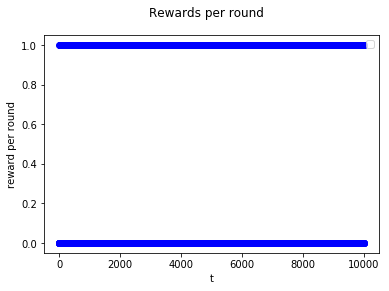

In [13]:
x_axis = range(rounds)
def plot_rewards(x_axis, rewards):
    fig = plt.figure()
    line_1, = plt.plot(x_axis[:10000], rewards[:10000], 'bo')
    #print(rewards)
    plt.ylabel('reward per round')
    plt.xlabel('t')
    plt.legend(handles=[line_1])
    fig.suptitle("Rewards per round")
    fig.savefig('test.jpg')
    plt.show()
    
plot_rewards(range(rounds), rewards)

C:\Users\lucas\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:532: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001ED79884550> has a label of '_line0' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


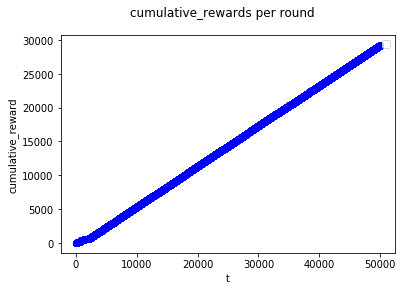

In [14]:
def plot_cumulative_rewards(cumulative_rewards):
    fig = plt.figure()
    line_1, = plt.plot(x_axis, cumulative_rewards, 'bo')

    plt.ylabel('cumulative_reward')
    plt.xlabel('t')
    plt.legend(handles=[line_1])
    fig.suptitle("cumulative_rewards per round")
    fig.savefig('test.jpg')
    plt.show()
    
plot_cumulative_rewards(cumulative_rewards)

C:\Users\lucas\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:532: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001ED775190B8> has a label of '_line0' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


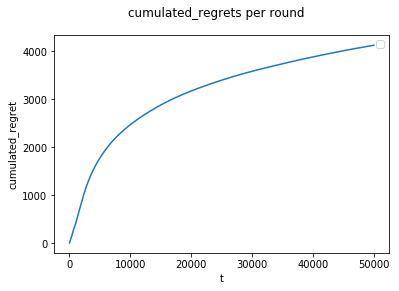

In [15]:
def plot_cumulated_regrets(cumulated_regrets):
    fig = plt.figure()
    line_1, = plt.plot(x_axis,cumulated_regrets)

    plt.ylabel('cumulated_regret')
    plt.xlabel('t')
    plt.legend(handles=[line_1])
    fig.suptitle("cumulated_regrets per round")
    fig.savefig('test.jpg')
    plt.show()
    
plot_cumulated_regrets(cumulated_regrets)
#plot_cumulated_regrets(regret_per_round)

In [ ]:
# do not need to struggle over the minor details
# do pay attention to certain definiotns
# make sure you understand the topic fluently
# make sure it's well structured. 